# Lab 3.07

In [64]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


#In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.



### Instructions


#### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.


In [467]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.film_id
, f.rental_duration
, r.rental_date
, r.customer_id
, f.special_features
, f.rating
, i.store_id
, r.staff_id
, f.length
FROM sakila.rental r
JOIN sakila.inventory i
USING (inventory_id)
JOIN sakila.film f
USING (film_id)
WHERE r.rental_date 
BETWEEN '2005-01-01' AND '2005-12-31';'''

sakila = pd.read_sql_query(query, engine)
sakila.head()

,film_id,rental_duration,rental_date,customer_id,special_features,rating,store_id,staff_id,length
0,80,7,2005-05-24 22:53:30,130,Trailers,G,1,1,148
1,333,7,2005-05-24 22:54:33,459,"Trailers,Behind the Scenes",R,2,1,126
2,373,7,2005-05-24 23:03:39,408,"Trailers,Behind the Scenes",G,2,1,156
3,535,6,2005-05-24 23:04:41,333,"Trailers,Behind the Scenes",R,1,2,181
4,450,5,2005-05-24 23:05:21,222,Trailers,NC-17,2,1,84


In [468]:
sakila.dtypes

film_id                      int64
rental_duration              int64
rental_date         datetime64[ns]
customer_id                  int64
special_features            object
rating                      object
store_id                     int64
staff_id                     int64
length                       int64
dtype: object

#### Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.

In [469]:
sakila['month'] = pd.DatetimeIndex(sakila['rental_date']).month

In [470]:
def bool_target(x):

    if x == 5:
        return 'True'
    else:
        return 'False'

In [471]:
sakila['target'] = sakila['month'].apply(bool_target)

In [472]:
sakila['target'].value_counts()

False    14706
True      1156
Name: target, dtype: int64

#### Read the data into a Pandas dataframe.

In [473]:
sakila.isna().sum()

film_id             0
rental_duration     0
rental_date         0
customer_id         0
special_features    0
rating              0
store_id            0
staff_id            0
length              0
month               0
target              0
dtype: int64

In [474]:
import matplotlib.pyplot as plt
import seaborn as sns

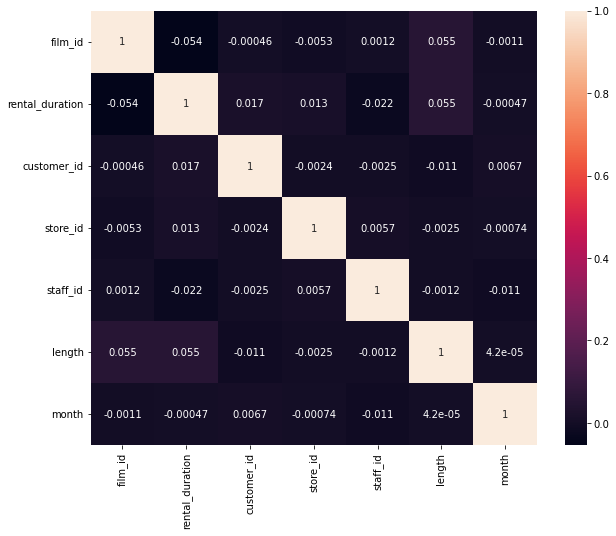

In [475]:
corr_matrix=sakila.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True) #annot=False gives just colors, not the numbers
plt.show()

In [476]:
sakila = sakila.drop(['rental_date', 'month'], axis=1)

#### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [477]:
sakila['rating'].value_counts()

PG-13    3543
NC-17    3249
PG       3178
R        3152
G        2740
Name: rating, dtype: int64

In [478]:
def cleanOperation(x):
    
    if  ((x =='R') | (x =='NC-17')):
        return "Adult"
    elif ((x =='PG-13')|(x =='PG')):
        return "Family"
    else:
        return 'General'


In [479]:
sakila['rating'] = list(map(cleanOperation, sakila['rating']))

In [480]:
y = sakila['target']
X = sakila.drop('target', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1337)

In [481]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [482]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,film_id,rental_duration,customer_id,store_id,staff_id,length
0,0.383383,0.50,0.951505,1.0,0.0,0.021583
1,0.176176,0.25,0.386288,1.0,1.0,0.906475
2,0.971972,0.25,0.234114,0.0,1.0,0.093525
3,0.984985,0.25,0.469900,0.0,0.0,0.467626
4,0.110110,0.00,0.366221,1.0,0.0,0.043165


In [483]:
X_train_categorical = X_train.select_dtypes(include = object)

In [484]:
X_train_categorical.head()

,special_features,rating
12013,Behind the Scenes,Adult
7649,"Commentaries,Deleted Scenes",Adult
2892,"Trailers,Deleted Scenes",Family
8219,Commentaries,Family
1830,"Commentaries,Deleted Scenes",Adult


In [485]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['special_features', 'rating'],
                             drop_first=True)
X_train_cat.head()

,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",rating_Family,rating_General
12013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7649,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2892,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
8219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1830,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [486]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [487]:
X_train_transformed

array([[0.38338338, 0.5       , 0.95150502, ..., 0.        , 0.        ,
        0.        ],
       [0.17617618, 0.25      , 0.38628763, ..., 0.        , 0.        ,
        0.        ],
       [0.97197197, 0.25      , 0.23411371, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.26326326, 0.75      , 0.54682274, ..., 0.        , 0.        ,
        1.        ],
       [0.89289289, 0.25      , 0.38795987, ..., 0.        , 1.        ,
        0.        ],
       [0.88888889, 0.        , 0.96153846, ..., 0.        , 0.        ,
        0.        ]])

#### Create a logistic regression model to predict this variable from the cleaned data.

In [488]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [489]:
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [490]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['special_features','rating'],
                            drop_first=True)
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns)))) 

X_test_cat.head()

C:\Users\franc\AppData\Local\Temp/ipykernel_1228/1023709137.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


[('special_features_Commentaries', 'special_features_Commentaries'),
 ('special_features_Commentaries,Behind the Scenes',
  'special_features_Commentaries,Behind the Scenes'),
 ('special_features_Commentaries,Deleted Scenes',
  'special_features_Commentaries,Deleted Scenes'),
 ('special_features_Commentaries,Deleted Scenes,Behind the Scenes',
  'special_features_Commentaries,Deleted Scenes,Behind the Scenes'),
 ('special_features_Deleted Scenes', 'special_features_Deleted Scenes'),
 ('special_features_Deleted Scenes,Behind the Scenes',
  'special_features_Deleted Scenes,Behind the Scenes'),
 ('special_features_Trailers', 'special_features_Trailers'),
 ('special_features_Trailers,Behind the Scenes',
  'special_features_Trailers,Behind the Scenes'),
 ('special_features_Trailers,Commentaries',
  'special_features_Trailers,Commentaries'),
 ('special_features_Trailers,Commentaries,Behind the Scenes',
  'special_features_Trailers,Commentaries,Behind the Scenes'),
 ('special_features_Trailers

,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",rating_Family,rating_General
11948,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
12275,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
529,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
15825,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
9807,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [491]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [492]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.9300273166631645

In [493]:
predictions

array(['False', 'False', 'False', ..., 'False', 'False', 'False'],
      dtype=object)

In [494]:
print(y_test.value_counts())

False    8852
True      666
Name: target, dtype: int64


In [495]:
pd.Series(predictions).value_counts()

False    9518
dtype: int64

In [496]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[8852,    0],
       [ 666,    0]], dtype=int64)

In [497]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform') #for these 3 neighbs, they will have the same weigh in this case
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.9274007144358059

In [498]:
confusion_matrix(y_test, predictions_clf)

array([[8823,   29],
       [ 662,    4]], dtype=int64)

In [499]:
pd.Series(y_test).value_counts()

False    8852
True      666
Name: target, dtype: int64

In [500]:
pd.Series(predictions_clf).value_counts()

False    9485
True       33
dtype: int64

#### Evaluate the results.

#### What can you do to make your model more accurate?